# Máquinas de Soporte Vectorial


### Desafío 1: Preparar el ambiente de trabajo
- Importe todas las librerías a utilizar.
- Fije los parámetros de los gráficos con plt.Rcparams .
- Excluya las columnas id y Unnamed: 32 de la base de datos.
- Recodifique el vector objetivo diagnosis a numérico para poder procesarlo posteriormente.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.svm import SVC

from sklearn.pipeline import Pipeline


In [2]:
import aux_func as func

In [3]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize']=(15, 10)

In [4]:
df = pd.read_csv("breast_cancer.csv").drop(columns=["Unnamed: 32", "id"])

In [5]:
#Asignamos valor 1 a los casos malignos
df['diagnosis'] = np.where(df['diagnosis'] == "M", 1, 0)

### Desafío 2: Visualizando la distribución de los atributos
- Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector objetivo.
- Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con una mayor similitud en la distribución.

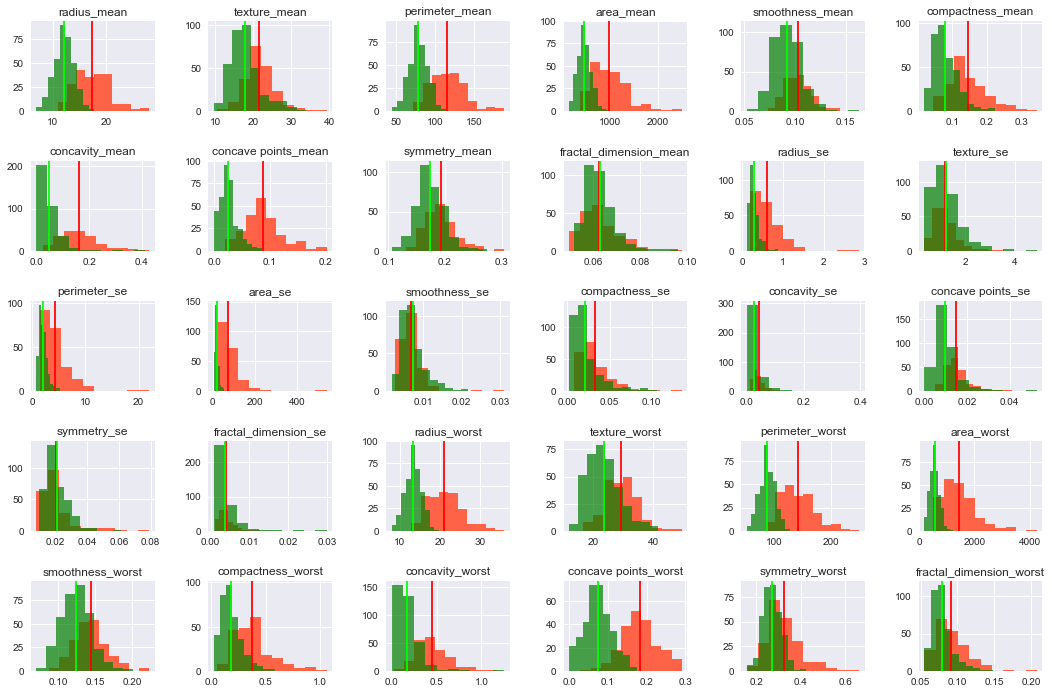

In [29]:
for j, i in enumerate(df.drop(columns='diagnosis').columns):
    plt.subplot(5,6,j+1)
    plt.title(i)
    plt.hist(df[df['diagnosis'] == 1][i], color="tomato")
    plt.axvline(np.mean(df[df['diagnosis'] == 1][i]), color='red')
    
    plt.hist(df[df['diagnosis'] == 0][i], color="green", alpha=0.7)
    plt.axvline(np.mean(df[df['diagnosis'] == 0][i]), color='lime')
plt.tight_layout(pad=2)


Los atributos con mayor similitud en la distribución son:
- `fractal_dimension_mean`
- `texture_se`
- `smoothness_se`
- `symmetry_se`
- `fractal_dimension_se`

### Desafío 3: Estimando el porcentaje de overlap en los atributos
- Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases no separables mediante el proceso de kernelización. Resulta que un aspecto importante que muchas veces se obvía es medir la noseparabilidad de los atributos, condicional a cada clase del vector objetivo.
- El procedimiento para estimar el rango de noseparabilidad entre clases se implementa enPython de la siguiente manera:

````
h1, _ = np.histogram(var1, bins=100) # estimamos la frecuencia de obs. en
100 espacios definidos
h2, _ = np.histogram(var2, bins=100) # estimamos la frecuencia de obs. en
100 espacios definidos
get_minima = np.minimum(h1, h2) # extraemos el mínimo de observaciones
comunes entre h1 y h2
intersection = np.true_divide(np.sum(get_minima), np.sum(tmp_2)) # Estimamos
la intersección de elementos comunes
````

- La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde mayores niveles indican una mayor comunalidad.
- Generalice el código de arriba en una función para evaluar el porcentaje de noseparabilidad entre las clases para cada atributo.
- Posteriormente genere un dataframe donde almacenará el nombre del atributo y su porcentaje. Ordene este dataframe de forma descendente y preserve

In [7]:
overlap = pd.DataFrame(columns=['atributo', 'porcentaje'])
porcentajes = []
atributos = []

In [8]:
for j, i in enumerate(df.drop(columns='diagnosis').columns):
    aux_diff = func.hist_diff(df[df['diagnosis'] == 1][i],df[df['diagnosis'] == 0][i])
    atributos.append(i)
    porcentajes.append(aux_diff)

In [9]:
overlap['atributo'] = atributos
overlap['porcentaje'] = porcentajes
overlap = overlap.sort_values('porcentaje',ascending=False)

In [10]:
overlap.head(10)

,atributo,porcentaje
9,fractal_dimension_mean,0.526611
15,compactness_se,0.523810
5,compactness_mean,0.518207
29,fractal_dimension_worst,0.518207
10,radius_se,0.515406
21,texture_worst,0.515406
18,symmetry_se,0.512605
8,symmetry_mean,0.509804
1,texture_mean,0.509804
24,smoothness_worst,0.501401


### Desafío 3: Selección del modelo por GridSearchCV
- Entrene una serie de modelos SVC con los siguientes hiperparámetros:
C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] .
gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10] .
Validaciones cruzadas: 10.
- Genere un heatmap en base a los puntajes estimados con GridSearchCV . tip: Vea cómo acceder a la llave mean_test_score en el diccionario cv_results_ .
- Reporte en qué rango de cada hiperparámetro el modelo presenta un desempeño eficiente.
- Reporte la mejor combinación de hiperparámetros y el desempeño en la muestra de entrenamiento.

In [11]:
X_scaled = StandardScaler().fit_transform(df.drop(columns='diagnosis'))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['diagnosis'], random_state=602,
test_size=.30)

In [12]:
params ={'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma':[0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10] }
svc = SVC(kernel="rbf")

In [13]:
model = GridSearchCV(svc, params, cv=10)
model.fit(X_train, y_train)

/Users/andres/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
cv_params = model.cv_results_['mean_test_score'].reshape(8,7)

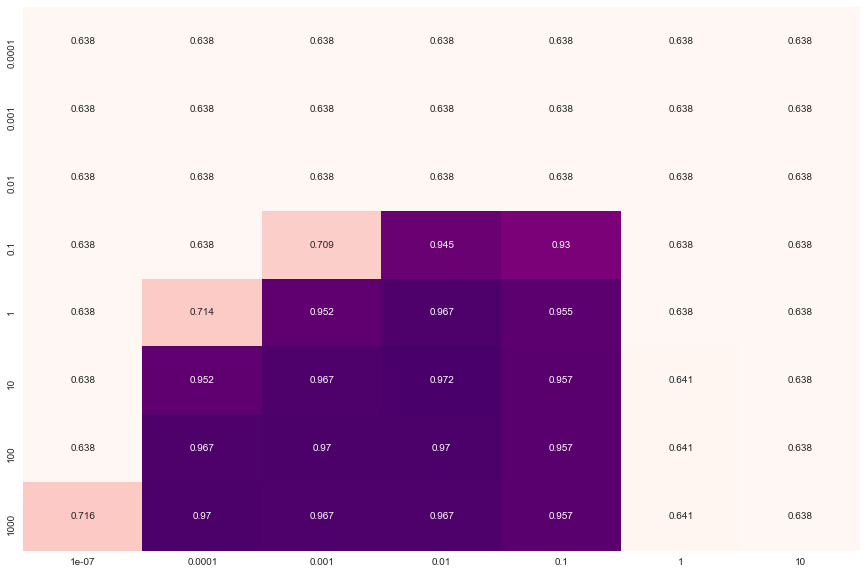

In [25]:
sns.heatmap(cv_params, annot=True, cmap='RdPu',
cbar=False, fmt=".3", xticklabels=params['gamma'], yticklabels=params['C'])

El rango de mejor desempeño es de 0.0001 y 0.01 para gamma y entre 100 y 10 para C

In [16]:
print("Los mejores parámetros son: {}".format(model.best_params_));
print("El resultados en la muestra de entretamiento es: {}".format(model.best_score_))

Los mejores parámetros son: {'C': 10, 'gamma': 0.01}
El resultados en la muestra de entretamiento es: 0.9723618090452262


### Desafío 4: Validación del modelo en el hold-out sample
- Genere las predicciones del hold-out sample en base a la mejor combinación de hiperparámetros. Genere un reporte con las métricas de desempeño clásicas para los modelos de clasificación. Comente en qué casos el modelo presenta un desempeño deficiente

In [17]:
model.best_estimator_.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       103
           1       1.00      0.96      0.98        68

   micro avg       0.98      0.98      0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



- El modelo tiene muy buenos resultados en todas las métricas
- El modelo tiene resultados un poco peores en `recall` para el caso de diagnósticos malignos, es decir para falla al predecir positivamente.

### Desafío (opcional): Depuración de atributos
- Reentrene el modelo en función de los atributos que presenten un coeficiente de overlap menor a .45.
- Reporte el desempeño del modelo y comente sobre los nuevos hiperparámetros estimados, así como su desempeño en comparación al modelo del ejercicio 4.

In [19]:
df_over45 = df.drop(columns=overlap[overlap['porcentaje']>0.45]['atributo'])

In [20]:
df_over45.columns

Index(['diagnosis', 'perimeter_mean', 'concavity_mean', 'perimeter_se',
       'area_se', 'smoothness_se', 'concavity_se', 'concave points_se',
       'fractal_dimension_se', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')

In [21]:
X_scaled2 = StandardScaler().fit_transform(df_over45.drop(columns='diagnosis'))

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, df_over45['diagnosis'], random_state=602,
test_size=.30)

model_over45 = GridSearchCV(svc, params, cv=10)
model_over45.fit(X_train2, y_train2)

print("Los mejores parámetros son: {}".format(model_over45.best_params_));
print("El resultados en la muestra de entretamiento es: {}".format(model_over45.best_score_))

Los mejores parámetros son: {'C': 1, 'gamma': 0.1}
El resultados en la muestra de entretamiento es: 0.957286432160804


/Users/andres/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


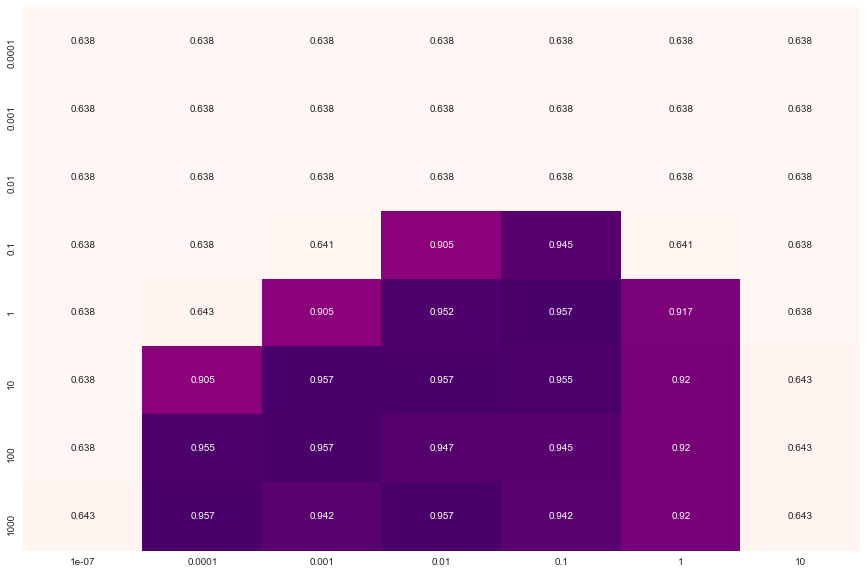

In [26]:
cv_params2 = model_over45.cv_results_['mean_test_score'].reshape(8,7)
sns.heatmap(cv_params2, annot=True, cmap='RdPu',
cbar=False, fmt=".3", xticklabels=params['gamma'], yticklabels=params['C'])

In [23]:
model_over45.best_estimator_.fit(X_train2, y_train2)
print(classification_report(y_test2,model_over45.predict(X_test2)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       103
           1       0.94      0.91      0.93        68

   micro avg       0.94      0.94      0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



- Para el nuevo caso solo considerando las variables con menor overlap, el valor de C disminuyó. Esto tiene sentido porque los valores deberían tender a ser más separables
- Por el lado contrario el valor de gama aumentó, es decir los puntos específicos de entrenamiento tienen un impacto mayor.
- El rendimiento general del nuevo modelo empeoró en todo los indicadores.